In [1]:
from multiprocessing import Pool,Process,Manager,cpu_count
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image,ImageFilter
import warnings
import scipy.optimize as opt
import scipy as sp
import cmath
import time 
import math

%matplotlib inline
warnings.filterwarnings('ignore')

font = {'family' : 'Ubuntu',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)


In [2]:
def ListofFiles(path):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             filelist.append(os.path.join(root,file))
    return filelist

def getImageValues(Files,EventLimit=1):
    if(type(Files) is list):
        values={}
        count=0
        for file in Files:
            img1=Image.open(file)
            imgArray=np.array(img1)
            values[count]=imgArray
            count+=1
            if(EventLimit==count):
                break
        print(f" {count} frames in dictinary ")
    else:
        img1=Image.open(Files)
        values=np.array(img1)
    return values

def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data



def TwoDGaussianElliptical(xy,Amp,x0,sigmax,y0,sigmay,theta,Shift):
    x,y=xy
    a=np.cos(theta)**2/(2*sigmax**2)+np.sin(theta)**2/(2*sigmay)
    b=-np.sin(2*theta)**2/(4*sigmax**2)+np.sin(2*theta)**2/(4*sigmay)
    c=np.cos(theta)**2/(2*sigmay**2)+np.sin(theta)**2/(2*sigmax)

    value=Shift+Amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return value

def TwoDGaussianEllipticalFlat(xy,Amp,x0,sigmax,y0,sigmay,theta,Shift):
    x,y=xy
    a=np.cos(theta)**2/(2*sigmax**2)+np.sin(theta)**2/(2*sigmay)
    b=-np.sin(2*theta)**2/(4*sigmax**2)+np.sin(2*theta)**2/(4*sigmay)
    c=np.cos(theta)**2/(2*sigmay**2)+np.sin(theta)**2/(2*sigmax)

    value=Shift+Amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return value.ravel()
        
def gaussian1d(mu,sigma,bins):
    return 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2))


def MaskCreate(pixel,radius,center,plot=False):
    XPixel,YPixel=pixel
    centerX,centerY=center
    centerX=np.mean(centerX)
    centerY=np.mean(centerY)

    x=np.arange(0,XPixel,1)
    y=np.arange(0,YPixel,1)
    xx,yy=np.meshgrid(x,y)
    rr=np.sqrt((xx-centerX)**2+(yy-centerY)**2)
    mask=rr<radius
    values=np.zeros(rr.shape)
    values[mask]=1
    if(plot):
        plt.figure(figsize=(12,8),dpi=300)
        plt.title("Mask Position")
        plt.xlabel("PixelX")
        plt.ylabel("PixelY")
        plt.imshow(values,cmap="gray",origin="lower")
        plt.show()
    
    return mask,values,[centerX,centerY]
    

    

def DrawCircle(centerx,centery,r,pixelSize,amount):
    x=np.arange(0,pixelSize,1).optimize
    xx,yy=np.meshgrid(x,x)
    rr=np.sqrt((xx-centerx)**2 + (yy-centery)**2)
    print(rr.shape)
    values=np.ones(rr.shape)*-1
    plt.figure(figsize=(12,8),dpi=300)
    count=0
    plt.title("Radial Average")
    #plt.xlim(0,512)
    #plt.ylim(0,512)
    print(r)
    for i in r:
        RadiusMask=(rr>=i-0.5)  & (rr<i+0.5)
        values[RadiusMask]=i
        if (count>=amount):
            break;
        count+=1
    plt.contourf(x,x,values,cmap='viridis',levels=r)
    plt.xlabel("kx")
    plt.ylabel("ky")
    plt.colorbar(label="k")
    plt.show()
    
def RadialFilter(wiener,size,xcenter,ycenter,radius):
    xx=np.linspace(0,size,size)
    grid=np.meshgrid(xx,xx)
    r=np.round(np.sqrt((grid[0]-xcenter)**2+(grid[1]-ycenter)**2))
    MaskIn=r<radius
    ones=np.zeros(r.shape)
    positions=np.where(MaskIn)
    print("XXX\n")
    print(grid[0])
    print("YYY\n")
    print(grid[1])
    print("RRR\n")

    print(r)
    positionR=np.floor(np.sqrt((positions[0]-xcenter)**2+(positions[1]-ycenter)**2))
    print(positionR.max())
    print(positionR.min())

    Wiener1d=np.array([])

    for i in positionR:
        Wiener1d=np.append(Wiener1d,wiener[int(i)])
        
    ones[MaskIn]=Wiener1d
    
    return ones

def TwoDGaussian(xy,Amp,x0,sigmax,y0,sigmay=None):
    x,y=xy
    if(sigmay==None):
        sigmay=sigmax
    value=Amp*np.exp(-((x-x0)**2/(2*sigmax**2)+(y-y0)**2/(2*sigmay**2)))
    return value



def RadialAverage(pws,radius,Amou,center=None):
    xp=np.arange(pws.shape[0])
    yp=np.arange(pws.shape[0])
    xx,yy=np.meshgrid(xp,yp)
    pws=np.fft.fftshift(pws)
    if not center:
        center=[pws.shape[0]/2,pws.shape[0]/2]
    R=np.sqrt((xx-center[0])**2+(yy-center[1])**2)
    
    radial = lambda r:pws[(R>=r-0.5) & (R<r+0.5)].mean()
    r=np.arange(1,radius,1)
    PWS1D=np.vectorize(radial)(r)
    return PWS1D

def my_ceil(a, precision=0):
    return np.true_divide(np.ceil(a * 10**precision), 10**precision)

def my_floor(a, precision=0):
    return np.true_divide(np.floor(a * 10**precision), 10**precision)



In [3]:
#Particles=PickleITRead("/home/ilker/Downloads/imgs.p")

In [4]:
##### 3 Source in a picture
#Get Enviroment Variable User
user=os.getenv('USER')

#Directory="/media/"+user+"/Ilker_SSD/10_07bar_6_21_23"
Directory="/home/"+user+"/Desktop/10_07bar_6_21_23"
# EL 13kV/cm
## Drift 440,250,125 V/cm
Folders=["17k_8k_7k","13.57k_4.57k_4k","11.3k_2.3k_2k"]

# EL 11kV/cm
## Drift 440,250,125 V/cm
#Folders=["16k_8k_7k","12.57k_4.57k_4k","10.3k_2.3k_2k"]


# EL 10kV/cm
## Drift 440,250,125 V/cm
#Folders=["15k_8k_7k","11.57k_4.57k_4k","9.5k_2.3k_2k"]
## "Time"
Time="14ms"
ff=Folders[0]
Path=Directory+"/"+ff+"/"+Time
Path="../data/10bar_7days_purified/Camera/CRAB_9_17_2023/17k_8k_7k/22ms/"
#Path=Directory+"/"+"s1"+"/"+Time
Images=getImageValues(ListofFiles(Path),-1)
#Images=getImageValues(ListofFiles("/home/argon/Projects/Ilker/CRAB_Diffusion/data/CRAB_9_17_2023/17k_8k_7k/14ms/"),-1)

SplitPath=Path.split("/")
Titlevalues=SplitPath[-2:]

 28000 frames in dictinary 


In [5]:
print(Titlevalues)

['22ms', '']


In [6]:
FixedSimg=Images[1]
#plt.imshow(Simg,cmap=plt.cm.jet,origin='lower',vmin=np.mean(Simg),vmax=np.max(Simg))


In [7]:
#plt.imshow(Images2[4],cmap=plt.cm.jet,origin='lower')
#plt.imshow(Images[200],cmap=plt.cm.jet,origin='lower',alpha=0.5)


In [8]:
## Average the images
def AvergImage(Images,rangex,Single=True,start=0):
    img=np.zeros(Images[0].shape)
    if (rangex>len(Images.keys())):
        rangex=len(Images.keys())
    # Average only one set
    if(Single):
        for i in range(start,rangex+start):
            img+=Images[i]
        img=img/rangex
        return img
    else: # Average Multiple Sets of Images
        cnt=0
        fImages=[]
        while(cnt<=len(Images.keys())-1):
            img+=Images[cnt]
            if (cnt%(rangex)==0 and cnt>0):
                fImages.append(img/rangex)
                img=np.zeros(Images[0].shape)
            cnt=cnt+1
        return fImages
    
    

In [9]:
theImage=AvergImage(Images,100,Single=True)


In [10]:
Error = lambda Observed,Expected:abs(Observed-Expected)/Expected
def WAverage(img):
    x = np.linspace(0, img.shape[0], img.shape[0])
    y=  np.linspace(0, img.shape[1], img.shape[1])
    xx, yy = np.meshgrid(x, y)

    PixelX=xx.ravel()
    PixelY=yy.ravel()
    
    
    weights1d=img.ravel()
    Mult1dX=np.sum(weights1d*PixelX)
    Sumweight1dX=np.sum(weights1d)
    ax=Mult1dX/Sumweight1dX
    
    
    Mult1dY=np.sum(weights1d*PixelY)
    Sumweight1dX=np.sum(weights1d)
    Mult1dY=np.sum(weights1d*PixelY)
    Sumweight1dY=np.sum(weights1d)
    ay=Mult1dY/Sumweight1dY
    
    return ax,ay
#x = np.linspace(0, theImage.shape[0], theImage.shape[0])
#y=  np.linspace(0, theImage.shape[1], theImage.shape[1])
#xx, yy = np.meshgrid(x, y)
#WeightedPixelX=np.average(xx,weights=theImage)
#WeightedPixelY=np.average(yy,weights=theImage)



In [11]:
def WeightedAverage(img,mask,Radius,f):
    ## Method 2 Weighted Average Estimation
    isPrint=f["isPrint"]
    
    x = np.linspace(0, img.shape[0], img.shape[0])
    y=  np.linspace(0, img.shape[1], img.shape[1])
    xx, yy = np.meshgrid(x, y)
    
    rr=np.sqrt(xx**2+yy**2)
    
    # Estimate the Max Intensity
    mAx=np.max(img[mask[0]])
    MaxMask2D=mAx==img*mask[0]
    MaxMask1D=mAx==img[mask[0]]
    
    # Estimate the Max Intensity in a given region
    Cmax=(np.where(MaxMask2D)[1],np.where(MaxMask2D)[0])
    
    if(isPrint):
        print(f"Max is {img[Cmax]} at {Cmax}")
    
    ## Create a Mask that is Centered in Maximum Intensity
    if(len(Cmax[0])>1 or len(Cmax[1])>1):
        print(f"CenterX is {Cmax[0]} and CenterY is {Cmax[1]}")
    cc=MaskCreate(img.shape,Radius,(Cmax[0],Cmax[1]),False)
    
    ## Estimate the Mean
    #Mean=np.average(img[cc[0]],weights=rr[cc[0]])
    
        ## Find the Pixel that is closest to mean
    #ErrorV=Error(img[cc[0]],Mean)
    #MinLoc=np.where(ErrorV==np.min(ErrorV))
    #PixelLoc=np.where(img*cc[0]==img[cc[0]][MinLoc])
    #print(PixelLoc)
   
    WeightedPixelX=np.average(xx[cc[0]],weights=img[cc[0]])
    WeightedPixelY=np.average(yy[cc[0]],weights=img[cc[0]])
    
    PixelX=xx[cc[0]]
    PixelY=yy[cc[0]]
    weightsA=img[cc[0]]
    
    np.average(PixelX*PixelY,weights=weightsA)
    if(isPrint):
        print(f"Weighted Average {(WeightedPixelX,WeightedPixelY)} ")
    return [[WeightedPixelX,WeightedPixelY],[Cmax[0][0],Cmax[1][0]]]
    

In [12]:

#theImage,Radius,NumberOfRings,PixelAmount,centerPoint
def RadialAverageRings(FitV):
    values=FitV["Img"]
    ## Create an array containing with pixel size of the image
    x=np.arange(0,FitV["Img"].shape[0],1)
    
    #Create a coordinate matrix from the pixel size
    xx,yy=np.meshgrid(x,x)
    ## if there is no center point defined then set it at (0,0)
    if FitV["Center"]:
        centerX,centerY=FitV["Center"]
    else:
        centerX,centerY=(0,0)
    R=np.sqrt((xx-centerX)**2+(yy-centerY)**2)
    Rings=np.linspace(0,FitV["Radius"],FitV["NumberOfCircles"])
    radialMean = lambda r:(values[(R>=r) & (R<(r+FitV["PixelIncrement"]))]).mean()
    vv=np.array([])
    for i in Rings:
        vv=np.append(vv,radialMean(i))
    return vv,Rings

In [13]:

def Lorentzian(x,a,x0,gamma,offset):
    denominator=np.pi*gamma*(1+((x-x0)/gamma)**2)
    result=((a*1)/(denominator))+offset
    return result

def Gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def Voigt_Fit(x,a,x0,gamma,sigma,offset):
   ## Lorentzian
    if (sigma==0 and gamma>0):
        return Lorentzian(x,a,x0,gamma,offset)
    ## Gaussian
    #elif (gamma==0 and sigma>0):
        #return Gauss(x, a, x0, sigma)
    top=np.vectorize(complex)((x-x0),gamma)
    z=top/(sigma*np.sqrt(2))
    wz=sp.special.wofz(z)
    denom=sigma*np.sqrt(2*np.pi)
    result=a*(np.real(wz)/denom)+offset
    return result

    
def Rsquared(ydata,f):
    mean=np.mean(ydata)
    SStot=np.sum((ydata-mean)**2)
    SSres=np.sum((ydata-f)**2)
    Rsqr=1-SSres/SStot
    return Rsqr


In [14]:


def PeakFinder(data,FitV):
    xlow=FitV["PeakRegion"][0]
    xhigh=FitV["PeakRegion"][1]
    step=FitV["PeakStep"]
    polarity=FitV["polarity"]
    isPrint=FitV["isPrint"]

    if(isPrint):
        print("Running Peak Finder Algorithm ..")
    ## First Get the lenth of the time
    Length=len(data[0])
    YProfile=np.array([])
    XProfile=np.array([])
    
    
    ## Obtain the max and min pixel
    if(not xlow and not xhigh):
        MinPixel=np.min(data[0])
        MaxPixel=np.max(data[0])
    else:
        MinPixel=xlow
        MaxPixel=xhigh
    
    #Start Time
    TempPixel=MinPixel
    if(isPrint):
        print(f"Max time is {MaxPixel}")
        print(f"Min time is {MinPixel}")
        print(f"Event Length is {Length}")

    for i in range(0, Length):
        if(TempPixel>=MaxPixel):
            if(isPrint):
                print("Max Pixel is reached")
            break
            
        PixelMask=(data[0]>=TempPixel) & (data[0]<=TempPixel+step ) 
        
        ## Check if there is any peak here
        if(np.sum(PixelMask)==0):
            TempPixel=TempPixel+step
            continue
         
        ## Obtain the minum
        if(polarity=="pos"):
            Max=np.max(data[1][PixelMask])
            AmpMask=data[1][PixelMask]==Max
        else:
            Min=np.min(data[1][PixelMask])
            AmpMask=data[1][PixelMask]==Min

        ## Only Negative Pulse        
        XProfile=np.append(XProfile,data[0][PixelMask][AmpMask])
        YProfile=np.append(YProfile,data[1][PixelMask][AmpMask])

        TempPixel=TempPixel+step 
    if(isPrint):
        print(f"Number of Peaks is {len(XProfile)}")
    return XProfile,YProfile
    
#Radius,AmountOfRings,GapDistance
def Obtain1DFit(FitV):
    ## Radius, Precision, 
    ## Obtain Gaussian by getting radial average 
    vvv=RadialAverageRings(FitV)
    
    ### Since this is symmetric in X axis flip the  data
    datax=-1*np.flip(vvv[1])
    datay=np.flip(vvv[0])
    datax=np.append(datax,vvv[1])
    datay=np.append(datay,vvv[0])

    #Normalize and Remove the DC offset
    datay=datay/np.max(datay)
    datay=datay-np.mean(datay[(datax>FitV["DCRegion"][0]) & (datax<=FitV["DCRegion"][1])])
    pks=PeakFinder([datax,datay],FitV)
    ## Plot the data vs fit
    if(FitV["isPlot"][0]):
        plt.figure(figsize=(8,8),dpi=200)
        plt.plot(datax,datay,'-o',label=FitV["labelx"])
    
    x=np.linspace(np.min(datax),np.max(datax),len(datax))
    R2=0
    #p0=np.max(pks[1]),1,30
    if (FitV["FitType"]=="Lorentz"):
        ## Lorentzian
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Lorentz"]
        parm,cov=opt.curve_fit(Lorentzian,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Lorentzian(x,*parm),linewidth=3,label=FitV["labelx"]+"_fit")
            
        #print(f"RSquared --> {}")
        R2=Rsquared(pks[1],Lorentzian(pks[0],*parm))
    elif (FitV["FitType"]=="Gaussian"):
        ## Lorentzian
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Gauss"]
        parm,cov=opt.curve_fit(Gauss,pks[0],pks[1],p0)
        if(FitV["isPlot"][0]):
            plt.plot(x,Gauss(x,*parm),linewidth=3,label=FitV["labelx"]+"_fit")
        
    elif (FitV["FitType"]=="Voigt"):
        ## Lorentzian
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Voigt"]
        parm,cov=opt.curve_fit(Voigt_Fit,pks[0],pks[1],p0,maxfev=FitV["maxfev"])  
        if(FitV["isPlot"][0]):
            plt.plot(x,Voigt_Fit(x,*parm),linewidth=3,label=FitV["labelx"]+"_fit")
    else:
        ## Gauss(x, a, x0, sigma):
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Gauss"]
        parmG,cov=opt.curve_fit(Gauss,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Gauss(x,*parmG),linewidth=3,label="Gaussian_"+FitV["labelx"]+"_fit")
        
        ## Lorentzian(x,a,x0,gamma,offset)
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Lorentz"]
        parmL,cov=opt.curve_fit(Lorentzian,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Lorentzian(x,*parmL),linewidth=3,label="Lorentz_"+FitV["labelx"]+"_fit",color="red")
        
        ## Voigt_Fit(x,a,x0,gamma,sigma,offset):
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Voigt"]
        parmV,cov=opt.curve_fit(Voigt_Fit,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Voigt_Fit(x,*parmV),linewidth=3,label="Voigt_"+FitV["labelx"]+"_fit",color="green")
        parm=np.array([parmG,parmL,parmV])
    
    if(FitV["isPlot"][0]):
        plt.scatter(pks[0],pks[1],marker='^',color="red",s=200)
        plt.xticks(np.arange(-FitV["Radius"],FitV["Radius"],10))
        plt.grid(axis="x")
        plt.legend(loc='upper right',prop={'size':10})

        if(FitV["isVLines"][0]):
            VLines(FitV["isVLines"][1],FitV["isVLines"][2],FitV["isVLines"][3])
        if(FitV["isPlot"][1]):
            plt.show()
    return parm,pks,R2

def VLines(startx,endx,increment):
    arry=np.arange(startx,endx,increment)
    for i in arry:
        plt.axvline(i,0,color="red")

In [15]:
## Magnification Formula
Mag=lambda ActualImageSize,AmountOfPixel,PixelSize:ActualImageSize/(AmountOfPixel*PixelSize) 
## Size of the Pixels in Camera
pixelSize=16e-3 #mm
#Calculate the Magnefication
Magnefication=Mag(2.5,10,pixelSize)
#Magnefication=10
#print(f" Magnefication is {Magnefication}")


In [16]:
print(Magnefication)

15.625


In [17]:
def LowPass(img,rad):
    low=MaskCreate(img.shape,rad,[img.shape[0]/2,img.shape[1]/2])
    Filter=np.fft.fftshift(low[0])
    imgreal=np.fft.fft2(img)
    imgreal=imgreal*Filter
    imgreal=np.fft.ifft2(imgreal)
    imgreal=np.real(imgreal)
    return imgreal


In [18]:
#print(Array[2])

In [19]:
def ConvertToDiffusion(SigmaX,SigmaY,distance,pixelSize,Magnefication,DT=0.92):
    DTX=round((SigmaX/np.sqrt(distance))*pixelSize*Magnefication,2)
    DTY=round((SigmaY/np.sqrt(distance))*pixelSize*Magnefication,2)
    value=round((DTX+DTY)/2,2)
    Error=round(abs(DT-value)/DT,2)
    print(f"Needle Distance is {distance} cm")
    print(f"DT is {value} mm/sqrt(cm) error is {Error*100} %")

def GetTransVerseDiffusion(Fit,pixelSize,mag):
    DTs=np.array([])
    SigmaXs=np.array([])
    SigmaYs=np.array([])
    positions=[2,7,12]
    
    for i in positions:
        DTX=Fit[3][i]*pixelSize
        DTY=Fit[3][i+2]*pixelSize
        DT=((DTX+DTY)/2)*mag
        
        DTs=np.append(DTs,DT)
        SigmaXs=np.append(SigmaXs,Fit[3][i])
        SigmaYs=np.append(SigmaYs,Fit[3][i+2])
        
    #Error=round(abs(DT-value)/DT,2)
    return DTs,SigmaXs,SigmaYs
    

def getGammas(Fit,pixelSize):
    DTs=np.array([])
    SigmaXs=np.array([])
    SigmaYs=np.array([])
    positions=[2,7,12]
    
    for i in positions:
        DTX=Fit[3][i]
        DTY=Fit[3][i+2]
        DT=(DTX+DTY)/2
        
        DTs=np.append(DTs,DT)
        SigmaXs=np.append(SigmaXs,Fit[3][i])
        SigmaYs=np.append(SigmaYs,Fit[3][i+2])
        
    #Error=round(abs(DT-value)/DT,2)
    return DTs,SigmaXs,SigmaYs

In [20]:
def Lorentzian2D(xy,a,x0,gx,y0,gy):
    x,y=xy
    denominator=np.pi*gx*gy*(1+((x-x0)/gx)**2+((y-y0)/gy)**2)
    result=((a*1)/(denominator))
    return result

def Sumsof3Lorentzian(xy,*initials):
    fit1=initials[0:5]
    fit2=initials[5:10]
    fit3=initials[10:15]
    offset=initials[-1:]
    Sum=Lorentzian2D(xy,*fit1)+Lorentzian2D(xy,*fit2)+Lorentzian2D(xy,*fit3)+offset
    return Sum.ravel()

def FitSumsof3Lorentzian(img,fit1,fit2,fit3,offset,it=15000):
    x = np.linspace(0,img.shape[0],img.shape[0])
    xx, yy = np.meshgrid(x, x)
    flattened=img.ravel()
    popt, pcov = opt.curve_fit(Sumsof3Lorentzian, (xx, yy),flattened , p0=(*fit1,*fit2,*fit3,offset),maxfev=it,method="dogbox")
    #print(popt)
    data_fitted = Sumsof3Lorentzian((xx, yy),*popt)
    return flattened.reshape(512,512),data_fitted.reshape(512,512),[xx,yy],popt    

In [21]:
# Obtain Single Fit
## 3 Fit Dictionary and Number of Pictures to analyze and Radius for masking to find the center
def SingleFit(Fitv1,Fitv2,Fitv3,theImg,Values=None,Amount=100,RR=[60,30],isLowPass=[False,10]):
    ## Average the images
    if(theImg is None):
        theImg=AvergImage(Images,Amount,True)
        Fitv1["Img"]=Fitv2["Img"]=Fitv3["Img"]=theImg
    else:
        Fitv1["Img"]=Fitv2["Img"]=Fitv3["Img"]=theImg
    #theImage=np.fft.fft2(theImage)*Wiener["WienerandLowPass"]
    #theImage=np.fft.ifft2(theImage)
    #theImage=np.real(theImage)
    
    #Create A Mask Layer
    PixelShape=theImg.shape
    CenterPoint=(215,270)
    Needle15cmMask=MaskCreate(PixelShape,RR[0],CenterPoint)

    CenterPoint=(298,297)
    Needle10cmMask=MaskCreate(PixelShape,RR[0],CenterPoint)

    CenterPoint=(261,180)
    Needle5cmMask=MaskCreate(PixelShape,RR[0],CenterPoint)

    
    
    ## Find the Weighted Pixel Value
    if(isLowPass[0]):
        theImg=LowPass(theImg,isLowPass[1])
    Needle5cm_Center=WeightedAverage(theImg,Needle5cmMask,RR[1],Fitv1)[0]
    Needle10cm_Center=WeightedAverage(theImg,Needle10cmMask,RR[1],Fitv2)[0]
    Needle15cm_Center=WeightedAverage(theImg,Needle15cmMask,RR[1],Fitv3)[0]
    
    Needle15cmMask=MaskCreate(PixelShape,RR[0],Needle15cm_Center)

    Needle10cmMask=MaskCreate(PixelShape,RR[0],Needle10cm_Center)

    Needle5cmMask=MaskCreate(PixelShape,RR[0],Needle5cm_Center)

    
    initialGuess_needle_5cm=np.mean(theImg[Needle5cmMask[0]]), Needle5cm_Center[0],Fitv1["gamma"][0],Needle5cm_Center[1], Fitv1["gamma"][1]
    initialGuess_needle_10cm=np.mean(theImg[Needle10cmMask[0]]), Needle10cm_Center[0], Fitv2["gamma"][0],Needle10cm_Center[1],Fitv1["gamma"][1]
    initialGuess_needle_15cm=np.mean(theImg[Needle15cmMask[0]]), Needle15cm_Center[0], Fitv3["gamma"][0], Needle15cm_Center[1],Fitv1["gamma"][1]
    ## Get the fits
    Fit_3Lorentzian=FitSumsof3Lorentzian(theImg,initialGuess_needle_5cm,initialGuess_needle_10cm,initialGuess_needle_15cm,Fitv1["offset"])
    if(Fitv1["isPlot"] or Fitv2["isPlot"] or Fitv3["isPlot"]):
        plt.figure(figsize=(12,12),dpi=300)
        plt.imshow(Fit_3Lorentzian[0], cmap=plt.cm.jet, origin='lower',vmin=np.mean(theImg),vmax=np.max(theImg))
        plt.contour(Fit_3Lorentzian[2][0], Fit_3Lorentzian[2][1], Fit_3Lorentzian[1], 10, colors='w')
    #print(f1)
    gg=getGammas(Fit_3Lorentzian,pixelSize)
    
        ### If Values are not None
    if(Values is not None):
        ## Append All the gamma values
        for i in range (0,3):
            #if(r2[i]>0.99): ### Remove anything does not fit well
            Values[i].append(np.abs(gg[0][i]))
    else:
        return gg


## run fit using multi-thread  
def MultiProcessManager(Fitv1,Fitv2,Fitv3,NProcess,SharedArray,Amount=100,RMask=[60,30]):
    startT=time.time()
    AveragedImages=AvergImage(Images,Amount,False)
    MaxNumEvents=len(AveragedImages)
    
    ## obtain the CPU info
    '''if(NProcess>int(cpu_count())):
        print(f"Your CPU count is {cpu_count()} less than the Number of Process {NProcess } therefore we are selecting the Number of Process to be {cpu_count()}\n")
        NProcess=int(cpu_count())
    '''    
    print("Total Number of Averaged Images to Fit = " +str(MaxNumEvents) )
    print("Number of Processes = " +str(NProcess) )

    
    if(NProcess<0):
        NProcess=MaxNumEvents
        
    if(MaxNumEvents%NProcess==0):   
        NumOfRuns=(int)(MaxNumEvents/NProcess)
    else:
        NumOfRuns=math.ceil(MaxNumEvents/NProcess)
    print("Number of Runs = " +str(NumOfRuns) )

   
    
    print("Starting the Simulation ....")
    
    EventCount=0
    
    Processes=[]
    ## Loop Through of the runs
    NumofEvents=MaxNumEvents
    
    for run in range(0,NumOfRuns):
        print("Starting Run " +str(run+1)+" out of " + str(NumOfRuns))
        
        ### Determine the Number Of Events to Process in each loop
        if(NumofEvents<0): break # break the code if it is negative
            
        reminder=NumofEvents%NProcess
        if (NumofEvents>=NProcess): 
            LoopValue=NProcess 
        else:
            LoopValue=reminder
        print("Expected Number of Events For This Run = " + str(LoopValue))
        #Start the process
        for event in range(0,LoopValue):
            proc=Process(target=SingleFit,args=(Fitv1,Fitv2,Fitv3,AveragedImages[event],SharedArray,Amount,RMask))
            Processes.append(proc)
            #time.sleep(1) ## Introduce 2 seconds delay so it will help to keep results in order
            proc.start()
            EventCount+=1
        
        # Complete     
        for p in Processes:
            p.join()
            #time.sleep(1) ## Introduce 2 seconds delay so it will help to keep results in order

        Processes.clear()
            
        NumofEvents=MaxNumEvents-EventCount
    endT=time.time()
    print("Time elapsed:" +str(endT-startT))
           

In [22]:
Fitv5cm={"Img":0, # Image of interest
     "Center":None, # Weighted Pixel Mean for the Needle
     "Radius":60, # Maximum Radius the analysis will be performed
     "gamma":[10,10], # Passing Initials for fitting parameters
     "isPrint":False, # Passing Initials for fitting parameters 
     "offset":10,
      "isPlot":[False,False]   
    
    }
Fitv10cm={"Img":0, # Image of interest
     "Center":None, # Weighted Pixel Mean for the Needle
     "Radius":60, # Maximum Radius the analysis will be performed
     "NumberOfCircles":200, # Number of Co-centric Circles
     "gamma":[20,20], # Passing Initials for fitting parameters
     "isPrint":False, # Passing Initials for fitting parameters
     "isPlot":[False,False]       

    }
Fitv15cm={"Img":0, # Image of interest
     "Center":None, # Weighted Pixel Mean for the Needle
     "Radius":60, # Maximum Radius the analysis will be performed
     "gamma":[30,30], # Passing Initials for fitting parameters  
     "isPrint":False, # Passing Initials for fitting parameters  
     "isPlot":[False,False]     
    }

[14.1172863  18.93846034 22.79805138]


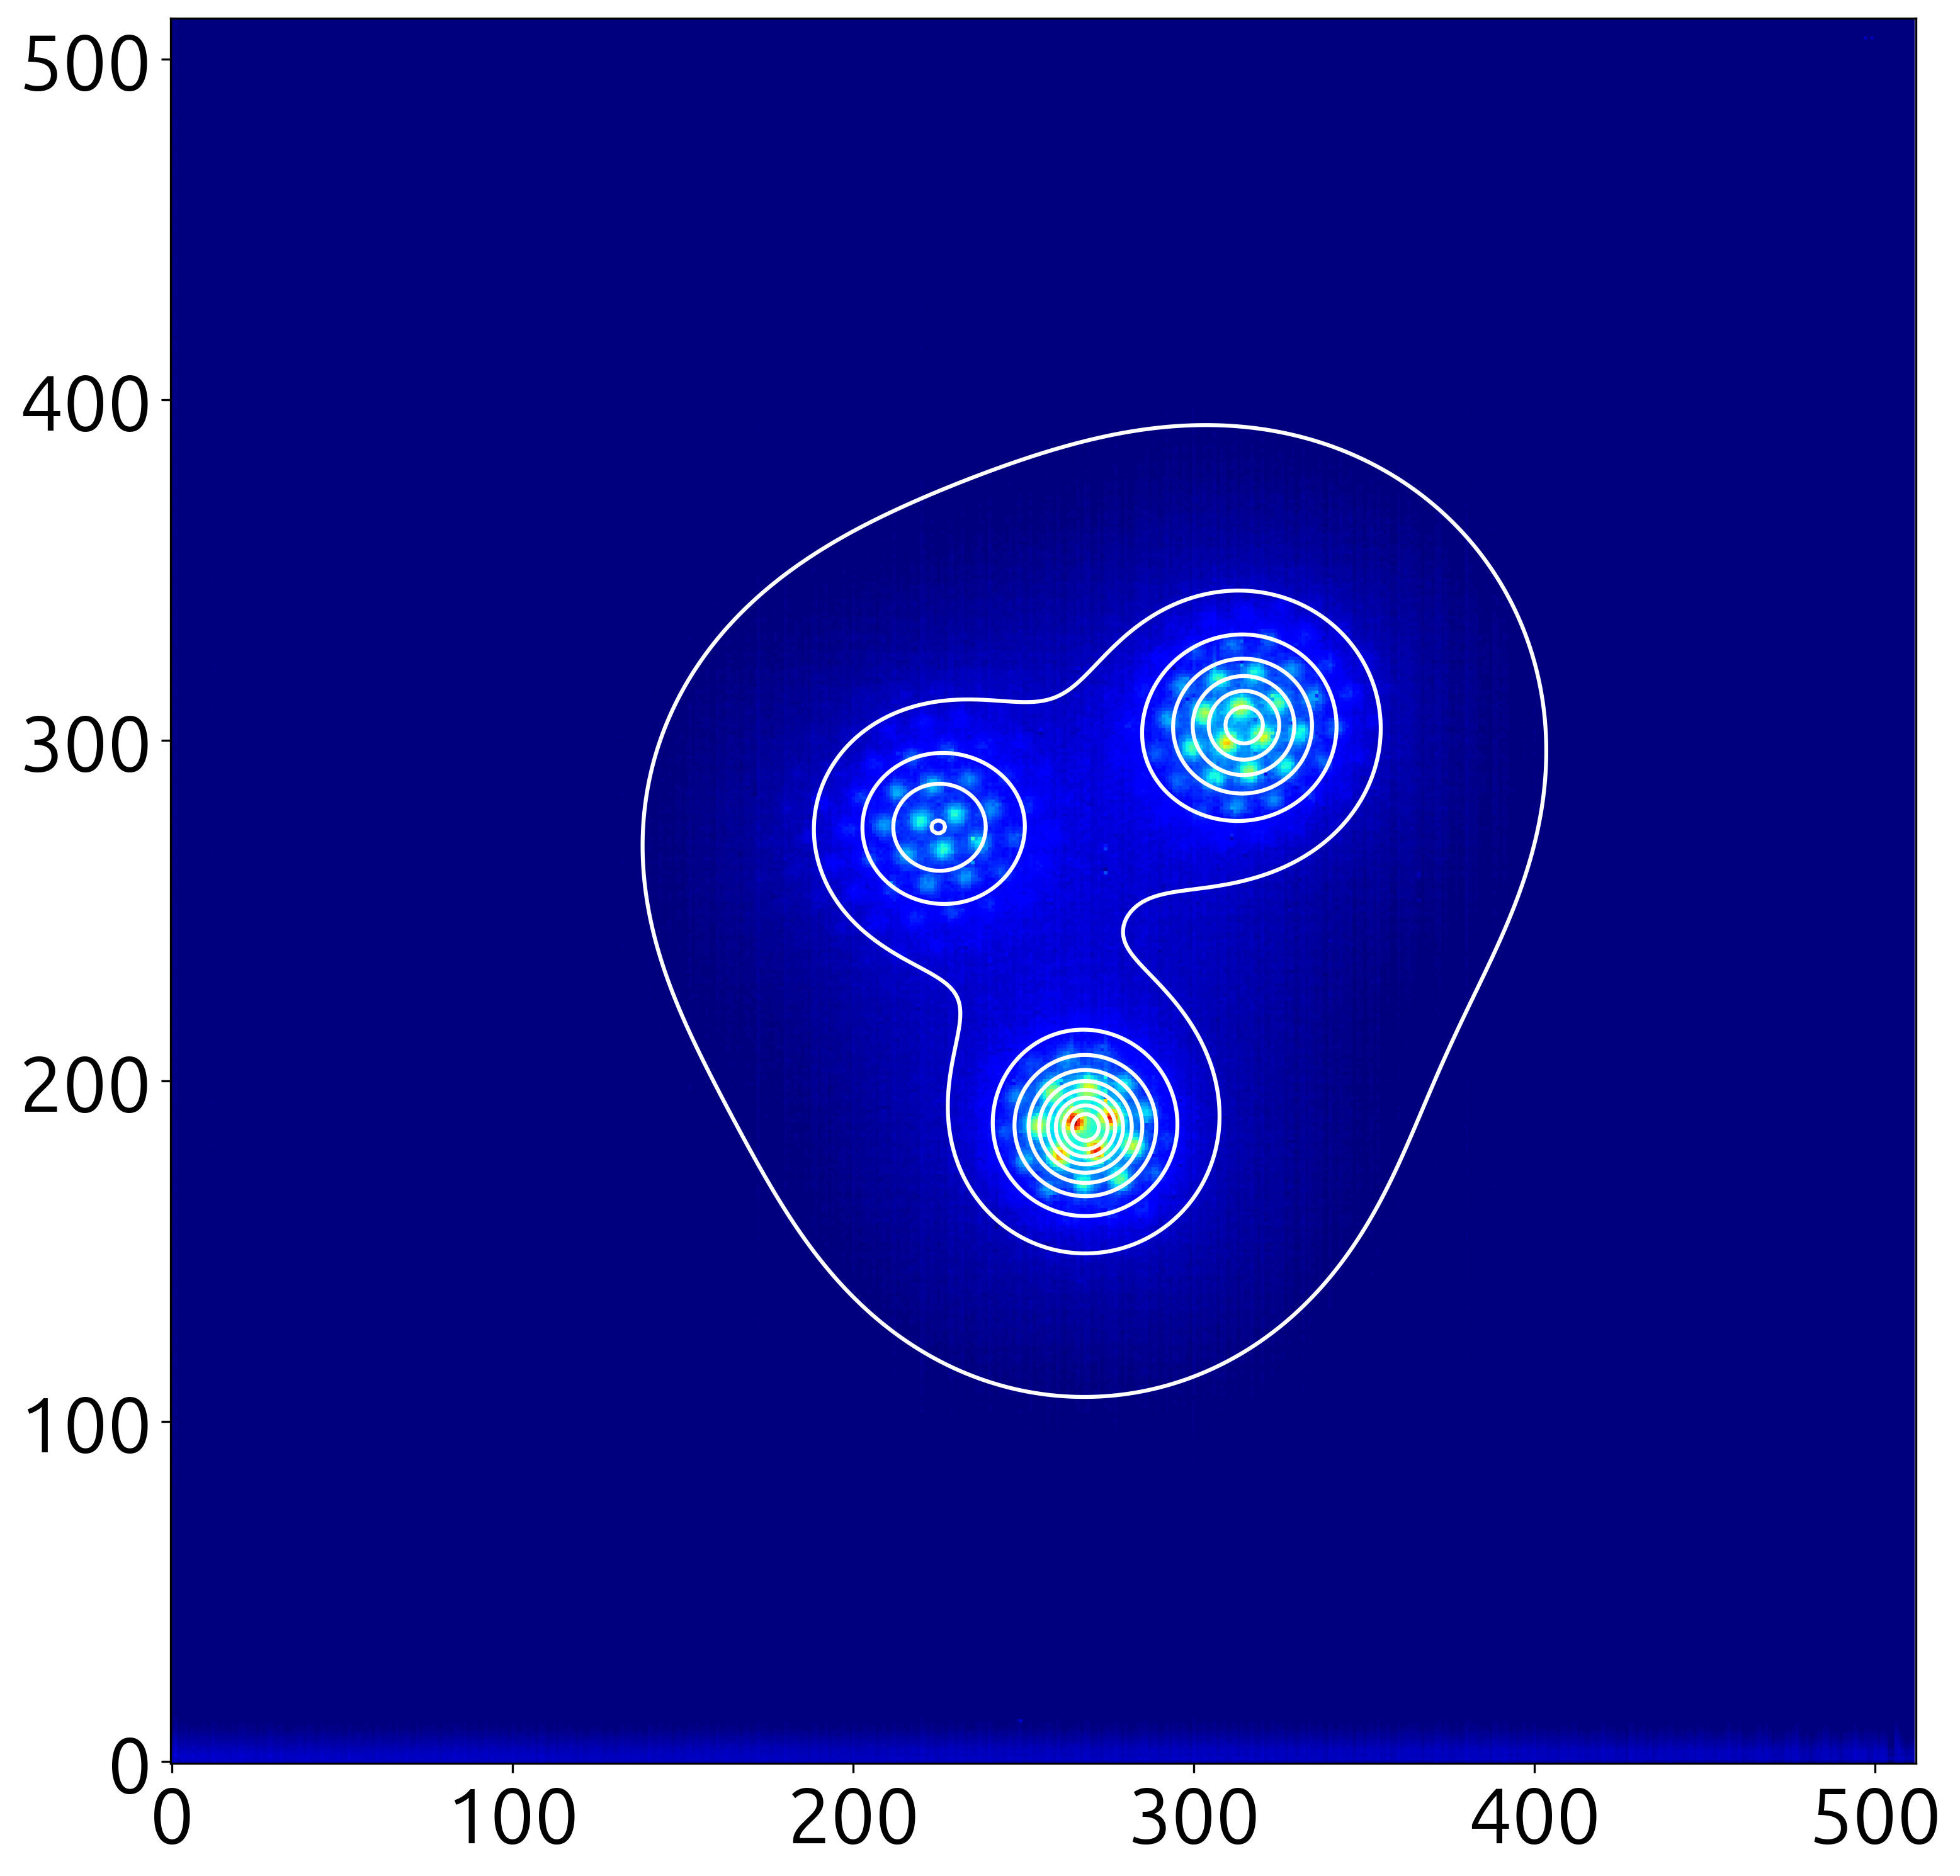

In [23]:
Event=1
Amount=2000
startxx=(Event*Amount)

theone=AvergImage(Images,Amount,True,startxx)
NeedleDistances=np.array([4.06,9.18,14.15])
k=SingleFit(Fitv5cm,Fitv10cm,Fitv15cm,theone,RR=[70,40])[1]
print(k)

In [24]:
#define MultiProcess Manager
manager=Manager()
## Create array to store all gammas
Array=manager.list([manager.list([]),manager.list([]),manager.list([])])

## Multi-Fit with Multi-Thread
MultiProcessManager(Fitv5cm,Fitv10cm,Fitv15cm,32,Array,Amount=2000,RMask=[70,40])

Total Number of Averaged Images to Fit = 13
Number of Processes = 32
Number of Runs = 1
Starting the Simulation ....
Starting Run 1 out of 1
Expected Number of Events For This Run = 13
Time elapsed:40.251362562179565


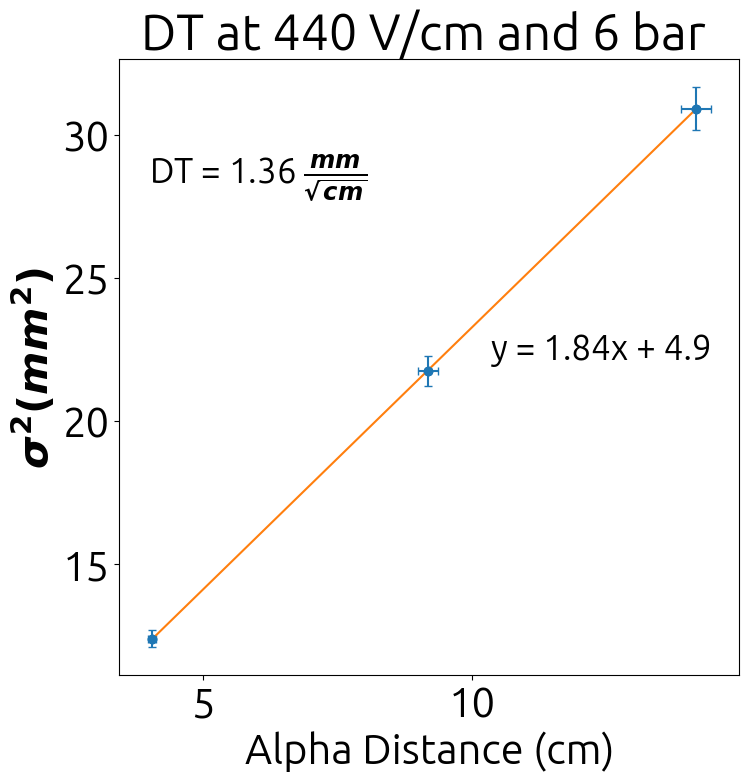

NeedleDistances is [ 4.06  9.18 14.15] in cm
Diffusion is [1.74604099 1.53890081 1.47849462] mm/sqrt(cm)


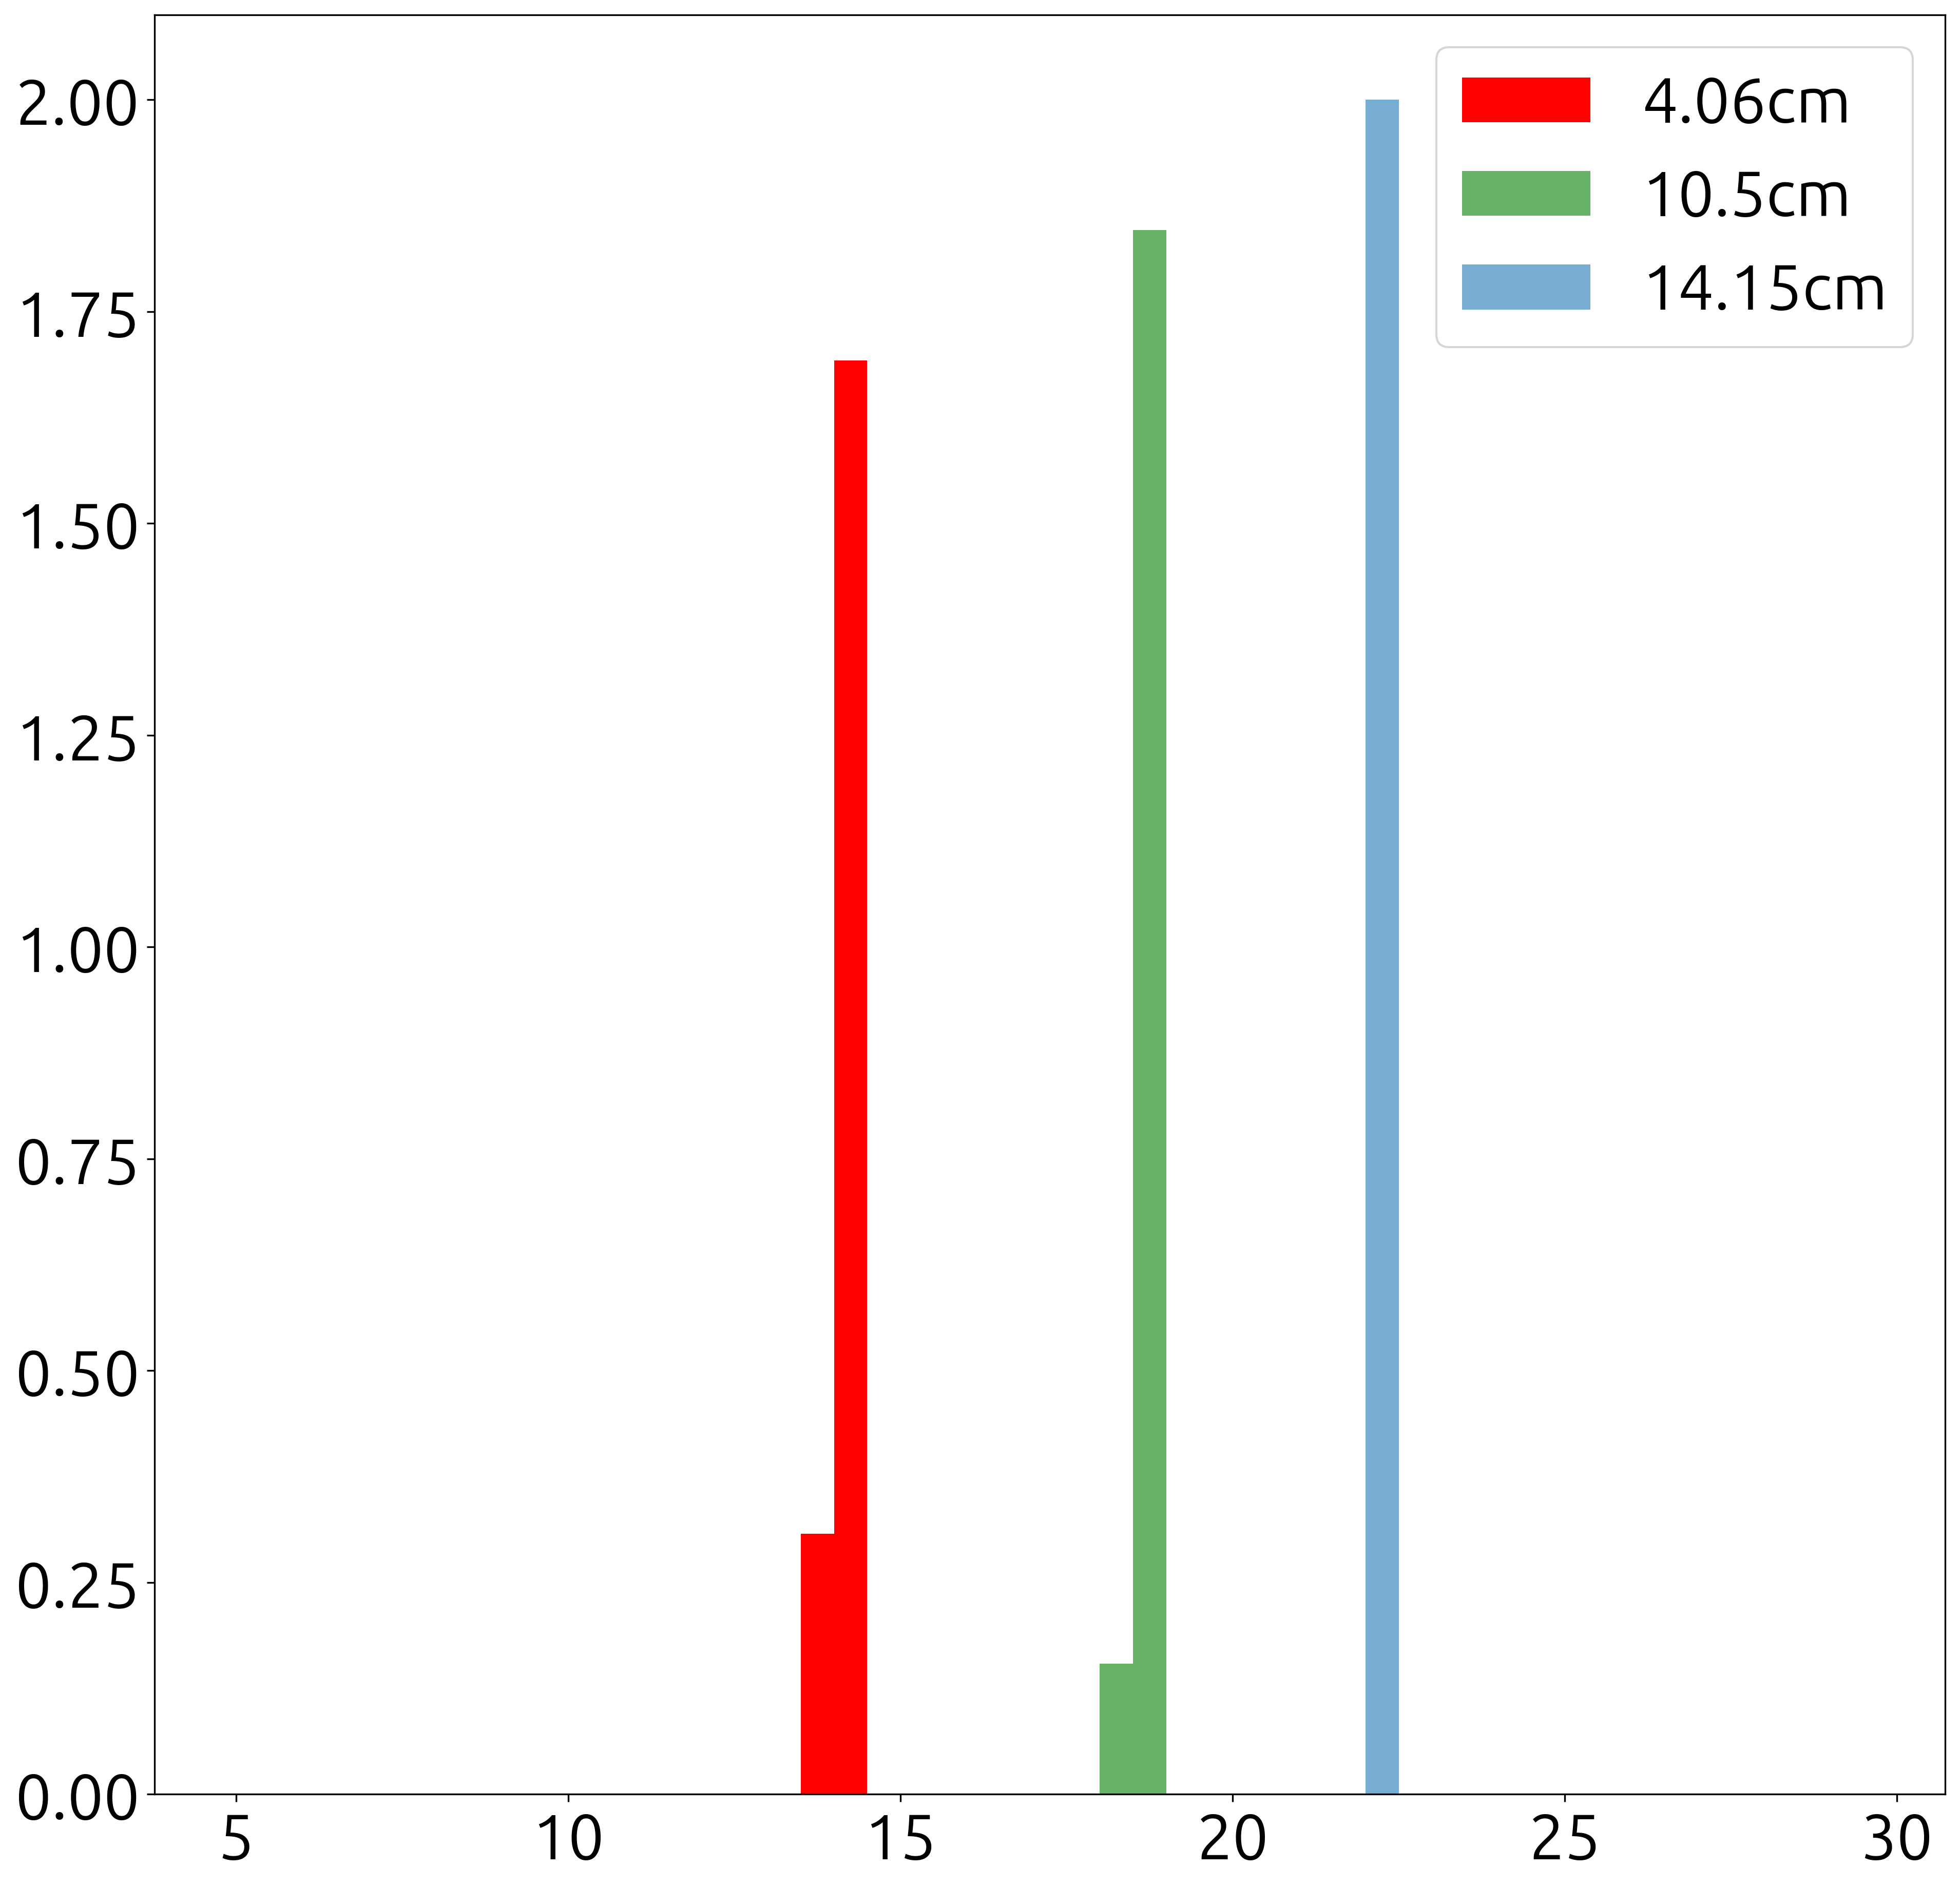

In [25]:
## Obtain STD and Mean
plt.figure(figsize=(8,8))
Title=f"DT at 440 V/cm and 6 bar "
plt.title(Title)

stds=np.array([np.std(Array[0]),np.std(Array[1]),np.std(Array[2])])
means=np.array([np.mean(Array[0]),np.mean(Array[1]),np.mean(Array[2])])
#NeedleDistances=np.array([5.46,10.58,15.55])
NeedleDistances=np.array([4.06,9.18,14.15])
NeedleDistanError=NeedleDistances*0.02

## Get the sigma squared
DD=means*pixelSize*Magnefication
## Error Propagation
Err=np.sqrt((stds/means)**2+(0.2/Magnefication)**2+(NeedleDistanError/NeedleDistances)**2)

slope, intercept = np.polyfit(NeedleDistances, DD**2, 1)
plt.scatter(NeedleDistances,DD**2)
plt.errorbar(NeedleDistances,DD**2,xerr=NeedleDistanError,yerr=((DD**2)*Err),fmt='o',capsize=3)
plt.plot(NeedleDistances,(slope*NeedleDistances+intercept))
plt.text(0.4,0.85,f"DT = {round(np.sqrt(slope),2)} " + r"$\frac{mm}{\sqrt{cm}}$",fontsize=25,horizontalalignment='right',verticalalignment='top',transform = plt.gca().transAxes)
#plt.text(5.8, 14, f"DT={D}" + r"$\frac{mm}{\sqrt{cm}}$", bbox=dict(facecolor='blue', alpha=0.5))
plt.text(0.6, 0.5,f"y = {round(slope,2)}x + {round(intercept,2)} ",fontsize=25,horizontalalignment='left',verticalalignment='bottom',transform = plt.gca().transAxes)
plt.xlabel("Alpha Distance (cm)")
plt.ylabel(r'$\sigma^2 (mm^2)$')
plt.show()
print(f"NeedleDistances is {NeedleDistances} in cm")
print(f"Diffusion is {DD/np.sqrt(NeedleDistances)} mm/sqrt(cm)")

plt.figure(figsize=(15,15),dpi=300)
plt.hist(Array[0],bins=np.arange(5,30,0.5),stacked=True,density=True,color="r",label="4.06cm")
plt.hist(Array[1],bins=np.arange(5,30,0.5),stacked=True,density=True,color="g",alpha=0.6,label="10.5cm")
plt.hist(Array[2],bins=np.arange(5,30,0.5),stacked=True,density=True,alpha=0.6,label="14.15cm")
plt.legend()
plt.show()